## Benchmarks

> This notebook contains code for training a small benchmark and exploring performance before moving on to the whole dataset. It also does some very basic hyperparameter exploration given the size of the dataset and the models used.

In [1]:
#| default_exp benchmark

In [71]:
!pip install -e ../

Obtaining file:///Users/dhritimansagar/Dev/dog_breed_id
  Preparing metadata (setup.py) ... done
  Attempting uninstall: dog_breed_id
    Found existing installation: dog_breed_id 0.0.1
    Uninstalling dog_breed_id-0.0.1:
      Successfully uninstalled dog_breed_id-0.0.1
  Running setup.py develop for dog_breed_id


In [2]:
#| export
from dog_breed_id.data_preprocessing import read_csv_with_array_columns
from dog_breed_id.research import get_classes_from_frame
from miniai.learner import *
from miniai.init import *
from miniai.activations import *
from miniai.datasets import show_images

import cv2
import fastcore.all as fc
from pathlib import Path
from PIL import Image
import pandas as pd
import numpy as np
import glob
import os
from matplotlib import pyplot as plt

import shutil
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
from torcheval.metrics import MulticlassAccuracy
from sklearn.model_selection import train_test_split
import timm

/Users/dhritimansagar/Dev/dog_breed_id/venv31013/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [73]:
df = read_csv_with_array_columns('../data/dogs.csv', ['bboxes'])

In [74]:
#| export
def get_id_mappings(df, include_background=True):
    classes = get_classes_from_frame(df, include_background=include_background)
    label2id = {label: i for i, label in enumerate(classes)}
    id2label = {i: label for i, label in enumerate(classes)}
    return label2id, id2label

def get_class_weights(df, label2id):
    weights = 1./df['category'].value_counts(normalize=True)
    weights = weights/weights.sum()
    keys = [label2id[l] for l in weights.index]
    order = np.argsort(keys)
    return torch.tensor(weights.values[order])

In [75]:
label2id, id2label = get_id_mappings(df, include_background=False)
weights = get_class_weights(df, label2id)

In [76]:
# order = np.argsort(keys)
# print(weights.loc['schipperke'])
# print(weights.loc['australian_shepherd'])
# weights.values[order]

In [77]:
#| export
def get_data_subsets(df, cache_path='../data', recreate=False):
    Path(cache_path).mkdir(parents=True, exist_ok=True)
    if not Path('../data/train.csv').exists() or recreate:
        train_subset, valid_subset = train_test_split(df, train_size=0.1, test_size=0.01, stratify=df['category'])
        valid_subset, test_subset = train_test_split(valid_subset, train_size=0.5, test_size=0.5)
        train_subset.to_csv('../data/train.csv')
        valid_subset.to_csv('../data/valid.csv')
        test_subset.to_csv('../data/test.csv')
    else:
        print('Cached files found, reading from disk')
        train_subset = read_csv_with_array_columns('../data/train.csv', ['bboxes'])
        valid_subset = read_csv_with_array_columns('../data/valid.csv', ['bboxes'])
        test_subset = read_csv_with_array_columns('../data/test.csv', ['bboxes'])
    return train_subset, valid_subset, test_subset

In [78]:
train_subset, valid_subset, test_subset = get_data_subsets(df)

Cached files found, reading from disk


In [79]:
#| export

class DogBreedClassificationDataset(Dataset):
    def __init__(self, df, label2id, id2label, transforms=None):
        super(DogBreedClassificationDataset, self).__init__()
        self.df = df
        if not transforms:
            self.transforms = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transforms = transforms
        self.label2id, self.id2label = label2id, id2label
    
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        item = self.df.iloc[idx]
        img = Image.open(item.image)
        tensor = self.transforms(img)
        label = self.label2id[item['category']]
        return tensor, label

TRAIN_TRANSFORMS = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ColorJitter(0.5, 0.5, 0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomErasing(p=0.1),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
VALID_TRANSFORMS = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [80]:
train_ds = DogBreedClassificationDataset(train_subset, label2id, id2label, TRAIN_TRANSFORMS)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128)

valid_ds = DogBreedClassificationDataset(valid_subset, label2id, id2label, VALID_TRANSFORMS)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=128)

test_ds = DogBreedClassificationDataset(test_subset, label2id, id2label, VALID_TRANSFORMS)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=128)

In [81]:
#| export
from functools import partial
iw = partial(init_weights, leaky=0.1)
def freeze_weights(p):
    p.requires_grad_(False)

def init_model(model, initialize=False, freeze_backbone=False):
    if initialize:
        model.apply(iw)
    if freeze_backbone:
        model.apply(freeze_weights)
    if hasattr(model, 'fc'):
        model.fc.requires_grad_(True)
    elif hasattr(model, 'head') and hasattr(model.head, 'fc'):
        model.head.requires_grad_(True)

In [82]:
astats = ActivationStats(fc.risinstance(torch.nn.ReLU))
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]

In [83]:
#| export
from collections import namedtuple

DataLoaders = namedtuple('DataLoaders', ['train', 'valid'])

In [84]:
dls = DataLoaders(train_dl, valid_dl)

In [85]:
#| export
class RegularizerCB(Callback):
    def __init__(self, alpha=0.01): fc.store_attr()
    
    def after_loss(self, learn):
        param_sum = sum([(p**2).sum() for p in learn.model.parameters()])
        param_sum *= self.alpha
        learn.loss += param_sum

## Exploring ResNet

**Learning Rate Finders** were first explored in the paper [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186). It is a technique which slowly increases the learning rate exponentially till the loss explodes. By observing a plot of the loss against the various learning rates, we can find the **best possible learning rates to use** for model training.

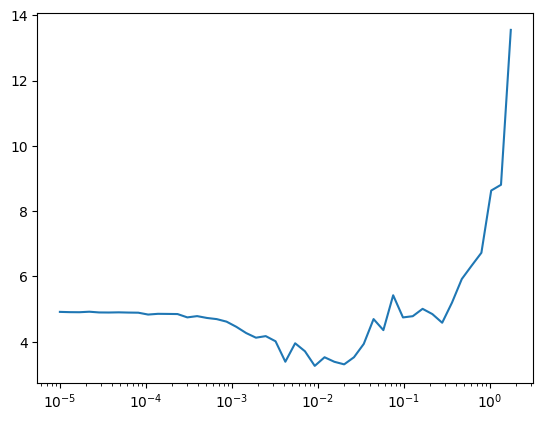

In [12]:
model = timm.create_model('resnet50', pretrained=True, num_classes=137)
init_model(model)
TrainLearner(model, dls=dls, loss_func=torch.nn.CrossEntropyLoss(), cbs=DeviceCB(), opt_func=torch.optim.Adam).lr_find()

So a learning rate of ~1e-3 seems appropriate for the task.

In [16]:
model = timm.create_model('resnet50', pretrained=True, num_classes=137)
init_model(model, initialize=False, freeze_backbone=False)
learner = TrainLearner(model, dls=dls, loss_func=torch.nn.CrossEntropyLoss(), cbs=cbs, opt_func=torch.optim.Adam)

accuracy,loss,epoch,train
0.398,2.673,0,train
0.736,1.029,0,eval
0.759,0.800,1,train
0.782,0.720,1,eval
0.843,0.493,2,train
0.798,0.744,2,eval
0.895,0.328,3,train
0.793,0.706,3,eval


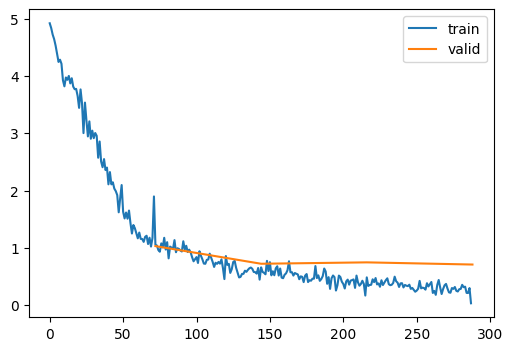

In [17]:
learner.fit(n_epochs=4, lr=0.001)

In [18]:
torch.save(model.state_dict(), 'resnet50_4e.pt')

As expected, on the small dataset, the model **overfits** to the training data and achieves an accuracy of 89% in only 4 epochs. Lets **add regularization** now and try simpler models.

In [17]:
model = timm.create_model('resnet50', pretrained=True, num_classes=137)
init_model(model, initialize=False, freeze_backbone=False)
learner = TrainLearner(model, dls=dls, loss_func=torch.nn.CrossEntropyLoss(), cbs=cbs+[RegularizerCB(alpha=5e-5)], opt_func=torch.optim.Adam)

accuracy,loss,epoch,train
0.387,55.359,0,train
0.732,47.563,0,eval
0.760,43.354,1,train
0.756,39.714,1,eval
0.833,36.608,2,train
0.745,34.355,2,eval
0.879,31.765,3,train
0.767,30.274,3,eval
0.912,28.061,4,train
0.705,27.345,4,eval


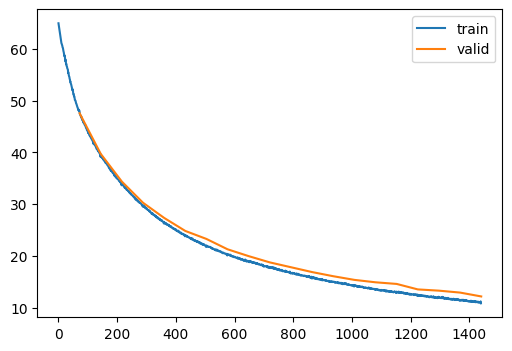

In [22]:
learner.fit(n_epochs=20, lr=0.001)

In [21]:
torch.save(model.state_dict(), 'resnet50_reg_5e-5.pt')

## Exploring ConvNeXt
ConvNeXt family of models were explored in the paper [A ConvNet for the 2020s](https://arxiv.org/abs/2201.03545). It is proposed a family of convolutional models which are competitive with Vision Transformers (the SOTA at the time for image classification). The timm library makes this model family easily accessible. 


In [18]:
model = timm.create_model('convnext_base', pretrained=True, num_classes=137)
init_model(model, initialize=False, freeze_backbone=True)
learner = TrainLearner(model, dls=dls, loss_func=torch.nn.CrossEntropyLoss(), cbs=cbs+[RegularizerCB(alpha=5e-5)], opt_func=torch.optim.Adam)

accuracy,loss,epoch,train
0.704,66.419,0,train
0.862,65.600,0,eval
0.846,65.577,1,train
0.864,65.557,1,eval
0.871,65.492,2,train
0.859,65.544,2,eval
0.886,65.445,3,train
0.857,65.539,3,eval
0.893,65.418,4,train
0.862,65.540,4,eval


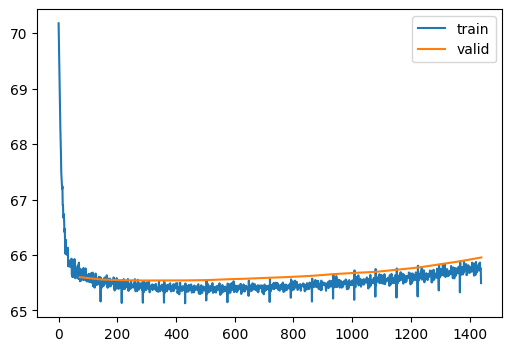

In [19]:
learner.fit(n_epochs=20, lr=0.001)

In [20]:
torch.save(model.state_dict(), 'convnext_base_reg_5e-5.pt')

## Test Set Performance 
So we notice that convnext has a better accuracy on validation set however resnet50 has better performance on the training set, supporting the assumption that resnet50 is overfitting on this small benchmark. Let's test the accuracy of both models on the test set.

In [16]:
resnet = timm.create_model('resnet50', pretrained=True, num_classes=137)
resnet.load_state_dict(torch.load('resnet50_reg_5e-5.pt'))

<All keys matched successfully>

In [86]:
resnet_earlystop = timm.create_model('resnet50', pretrained=True, num_classes=137)
resnet_earlystop.load_state_dict(torch.load('resnet50_4e.pt'))

<All keys matched successfully>

In [17]:
convnext = timm.create_model('convnext_base', pretrained=True, num_classes=137)
convnext.load_state_dict(torch.load('convnext_base_reg_5e-5.pt'))

<All keys matched successfully>

In [89]:
#| export
def get_classification_accuracy(model, dl):
    device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
    matches = []
    model.eval()
    model.to(device)
    for (imgs, labels) in dl:
        imgs = imgs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            logits = model(imgs)
        preds = logits.argmax(-1)
        matches.extend((preds == labels).cpu().tolist())
    return np.mean(matches)


def get_classification_accuracy_ensembled(models, dl):
    models = models if isinstance(models, list) else [models]
    device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
    matches = []
    [model.eval() for model in models]
    models = [model.to(device) for model in models]
    for (imgs, labels) in dl:
        imgs = imgs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            # Do bagging
            logits = sum([model(imgs) for model in models])
            logits = logits/float(len(models))
        preds = logits.argmax(-1)
        matches.extend((preds == labels).cpu().tolist())
    return np.mean(matches)

In [90]:
print(f'ResNet50 test set accuracy: {get_classification_accuracy(resnet, test_dl):.2f}')

ResNet50 test set accuracy: 0.69


In [91]:
print(f'ResNet50 (with early stopping) test set accuracy: {get_classification_accuracy(resnet_earlystop, test_dl):.2f}')

ResNet50 (with early stopping) test set accuracy: 0.76


In [93]:
print(f'ConvNeXt test set accuracy: {get_classification_accuracy(convnext, test_dl):.2f}')

ConvNeXt test set accuracy: 0.81


Thus overall, a **simple ConvNeXt performs best on the test set for this small benchmark problem.**

In [97]:
print(f'Ensemble test set accuracy: {get_classification_accuracy_ensembled([convnext, resnet, resnet_earlystop], test_dl):.2f}')

Ensemble test set accuracy: 0.81


Even in the case of an ensemble in this case, the convnext accuracy dominates that of the other two networks, showing a ConvNeXt as the best choice for this problem./

Even in the case of an ensemble in this case, the convnext accuracy dominates that of the other two networks, showing a ConvNeXt as the best choice for this problem.

In [3]:
#| hide
import nbdev; nbdev.nbdev_export()